Copying code from Dr Tanishq Abraham's blogpost <em>[Gradio + HuggingFace Spaces: A Tutorial](https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html)</em>

In [4]:
!pip install -q gradio | grep -v "Requirement"
!pip install -q duckduckgo_search | grep -v "Requirement"
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastai.vision.all import *
import gradio as gr
import os
import sys
from pathlib import Path

In [5]:
path = untar_data(URLs.PETS)
#Oxford-IIT Pet Dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/)
cats = {'abyssian',
        'bengal',
        'birman',
        'bombay',
        'british shorthair',
        'egyptian mau',
        'main coon',
        'persian',
        'ragdoll',
        'russian blue',
        'siamese',
        'sphynx'}
dogs = {'american bulldog',
        'american pit bull terrier',
        'basset hound',
        'beagle',
        'boxer',
        'chihuahua',
        'english cocker spaniel',
        'english setter',
        'german shorthaired',
        'great pyrenees',
        'havanese',
        'japanese chin',
        'keeshond',
        'leonberger',
        'miniature pinscher',
        'newfoundland',
        'pomeranian',
        'pug',
        'saint bernard',
        'samyoed',
        'scottish terrier',
        'shiba inu',
        'staffordshire bull terrier',
        'wheaten terrier',
        'yorkshire terrier'}

custom_path = Path(os.getcwd(), 'pets')

In [6]:
?ddg_images

Signature:
ddg_images(
    keywords,
    region='wt-wt',
    safesearch='moderate',
    time=None,
    size=None,
    color=None,
    type_image=None,
    layout=None,
    license_image=None,
    max_results=None,
    page=1,
    output=None,
    download=False,
)
Docstring: <no docstring>
File:      /usr/local/lib/python3.9/dist-packages/duckduckgo_search/compat.py
Type:      function


In [18]:
?download_url

Signature: download_url(url, dest=None, timeout=None, show_progress=True)
Docstring: Download `url` to `dest` and show progress
File:      /usr/local/lib/python3.9/dist-packages/fastdownload/core.py
Type:      function


In [25]:
def get_urls(term, max_urls=10):
    results = ddg_images(term, max_results=max_urls)
    results = L(results)
    return results.itemgot('image')

def download_images(terms, dest=Path(os.getcwd(), 'pets')):
    failed = 0
    succeeded = 0
    for term in terms:
        urls = get_urls(term)
        for url in urls:
            try:
                download_url(url, dest/f'{term}.jpg', show_progress=False)
                succeeded += 1
                break
            except:
                print(f'Failed to download image of {term} from {url}')
                failed += 1
    return succeeded, failed

download_images(cats)

(12, 0)

In [33]:
len(os.listdir(custom_path))

38

In [34]:
dls = ImageDataLoaders.from_name_re(path,
                                    get_image_files(path/'images'),
                                    pat='(.+)_\d+.jpg',
                                    item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224,min_scale=0.75))
learn = vision_learner(dls, models.resnet50, metrics=accuracy)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

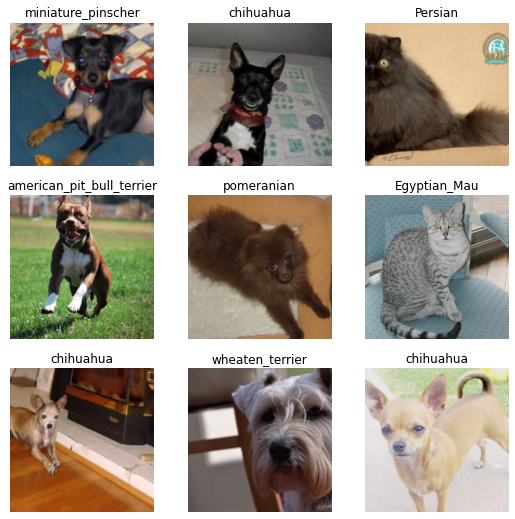

In [35]:
dls.show_batch()

In [46]:
learn.fine_tune(3)
learn.path=Path('.')
learn.export()

epoch,train_loss,valid_loss,accuracy,time
0,0.964620,0.355089,0.891746,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.446614,0.365944,0.885656,01:16
1,0.315035,0.313273,0.920839,01:15
2,0.161546,0.236327,0.928281,01:15


In [36]:
?load_learner

Signature:
load_learner(
    fname,
    cpu=True,
    pickle_module=<module 'pickle' from '/usr/lib/python3.9/pickle.py'>,
)
Docstring: Load a `Learner` object in `fname`, by default putting it on the `cpu`
File:      /usr/local/lib/python3.9/dist-packages/fastai/learner.py
Type:      function


In [47]:
learn = load_learner('export.pkl')

In [55]:
len(os.listdir(custom_path))


26

In [51]:
labels = learn.dls.vocab

def predict(img):
    img = PILImage.create(img)
    pred, pred_idx, probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title='Pet Breed Classifier'
description = ('Pet breed classifier trained on the Oxford Pets dataset' +
               'with the fastai library and the ResNet50 neural network architecture. ' +
               'Based on the tutorial by Dr Tanishq Abraham.')
article="<p style='text-align: center'><a href='https://tmabraham.github.io/blog/gradio_hf_spaces_tutorial' target='_blank'>Blog post</a></p>"

gr.Interface(fn=predict,
             inputs=gr.Image(),
             outputs=gr.Label(num_top_classes=3),
             title=title,
             description=description,
             article=article
            ).launch(share=True)

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://c1e6a8ba557a36fda1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
